In [1]:
from typing import List, Dict
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
plt.rcParams['figure.figsize']= [10, 8]

In [231]:
# def parse_fasta_dataset(file_path: str = "../data/LTP_09_2021_compressed_staph_muscle.fasta", max_seqs:int = False) -> List[Dict[str, str]]:
# def parse_fasta_dataset(file_path: str = "../data/LTP_09_2021_compressed.fasta", max_seqs:int = False) -> List[Dict[str, str]]:
def parse_fasta_dataset(file_path: str = "../data/LTP_09_2021_aligned_staph.fasta", max_seqs:int = False) -> List[Dict[str, str]]:
    dataset = []
    current_idx = 0
    current_meta = {}
    with open(file_path, "r") as f:
        for line in f.readlines():
            if line[0] == ">":
                if current_meta != {}:
                    current_meta["sequence"] = current_meta["sequence"].strip()
                    dataset.append(current_meta)
                line_list = line.replace("\n", "").replace(">", "").split("\t")
                if len(line_list) < 2:
                    current_meta  = {key: line_list[idx] for idx, key in enumerate(["name"])}
                elif len(line_list) < 3:
                    current_meta  = {key: line_list[idx] for idx, key in enumerate(["id", "name"])}
                else:
                    current_meta  = {key: line_list[idx] for idx, key in enumerate(["id", "name", "tags"])}
                    current_meta["tags"] = current_meta["tags"].split(";")
                current_meta["sequence"] = ""
                current_idx += 1
                if current_idx > max_seqs and max_seqs>=1:
                    break
            else:
                current_meta["sequence"] += line.replace("\n", " ")
    return dataset

dataset = parse_fasta_dataset(max_seqs=-1)
print(len(dataset))

67


In [234]:
staph_strains = [x for x in dataset if  "Staphyloc" in x['name']]

In [235]:
with open("../data/LTP_09_2021_compressed_staph.fasta", "w+") as f:
    for record in staph_strains:
#         f.write(">{id}\t{name}\t{tags}".format(id=record['id'], name=record['name'], tags=";".join(record['tags'])))
        f.write(">{id}\t{name}".format(id=record['id'], name=record['name']))
        f.write("\n")
        f.write(record['sequence'])
        f.write("\n")

In [236]:
# BASES = {"A": "000", "C": "001", "G": "010", "T": "011", "_": "100"}

# def is_valid_padding(key_string: str) -> bool:
#     if "_" not in key_string[:-2] and key_string[-1] == "_":
#         return True
#     elif "_" not in key_string[:-3] and key_string[-2:] == "__":
#         return True
#     elif "_" not in key_string[:-4] and key_string[-3:] == "___":
#         return True
#     return False

# BASE_MAP = {}

# for key1, val1 in BASES.items():
#     for key2, val2 in BASES.items():
#         for key3, val3 in BASES.items():
#             for key4, val4 in BASES.items():
#                 key_string = key1 + key2 + key3 + key4
#                 if "_" not in key_string:
#                     print(
#                         key1 + key2 + key3 + key4,
#                         "->",
#                         val1 + val2 + val3 + val4,
#                         "(",
#                         int(val1 + val2 + val3 + val4, base=2),
#                         ")",
#                     )
#                     BASE_MAP[key1 + key2 + key3 + key4] = int(
#                         val1 + val2 + val3 + val4, base=2
#                     )
#                 else:
#                     if is_valid_padding(key_string):
#                         print(
#                             key1 + key2 + key3 + key4,
#                             "->",
#                             val1 + val2 + val3 + val4,
#                             "(",
#                             int(val1 + val2 + val3 + val4, base=2),
#                             ")",
#                         )
#                         BASE_MAP[key1 + key2 + key3 + key4] = int(
#                             val1 + val2 + val3 + val4, base=2
#                         )

# for key, val in SPECIAL.items():
#     BASE_MAP[key] = val


# print(BASE_MAP)
# print(len(BASE_MAP))

In [237]:
def chunk_seq(seq: str, chunk_len: int = 4):
    ret_list = []
    chunk = ""
    for idx, char in enumerate(seq):
        chunk += char
        if len(chunk) % chunk_len ==0:
            ret_list.append(chunk)
            chunk=""
    if len(chunk) > 0:
        ret_list.append("{}{}".format(chunk, "_"*(4-len(chunk))))
    return ret_list

# clean_seq = dataset[0]["sequence"].replace(" ", "")
# chunks = chunk_seq(clean_seq)
# print(chunks)

In [298]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(chunk_seq(x["sequence"].replace(" ", ""), 15), [x["name"]]) for x in dataset]
# documents = [TaggedDocument(" ".join(chunk_seq(x["sequence"].replace(" ", ""), 32)), [x["name"]]) for x in staph_strains]

In [299]:
model = gensim.models.Doc2Vec(
#     epochs=50,
    documents=documents,
    workers=8,
    vector_size=300,
    window=15,
    min_alpha=0.001,
    alpha=1,
)

In [300]:
# [(x, y) for x, y in model.docvecs.doctags.items()]

In [301]:
# model.docvecs.doctags.keys()

In [302]:
seq_ids = {record["name"]: model.docvecs[record["name"]] for record in staph_strains}

In [303]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AffinityPropagation
from matplotlib import pyplot as plt
import seaborn as sns

def plot_nodes(seq_ids: Dict[str, np.array], figsize=(50,50)):
    X = np.array([x for x in seq_ids.values()])
    
    # reduce dimensions to 2
    pca = PCA(n_components=2) #, n_jobs=-1)
    result = pca.fit_transform(X)

    cluster = AffinityPropagation(random_state=42)
    cluster.fit(X)
    
    plt.figure(figsize=figsize)
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1], c=cluster.labels_, cmap=sns.color_palette("Spectral", as_cmap=True))
    for i, word in enumerate([x for x in seq_ids.keys()]):
        c = 'grey'
        if i in cluster.cluster_centers_indices_:
            c = 'black'
        plt.annotate(word, xy=(result[i, 0], result[i, 1]), c=c)
    plt.show()

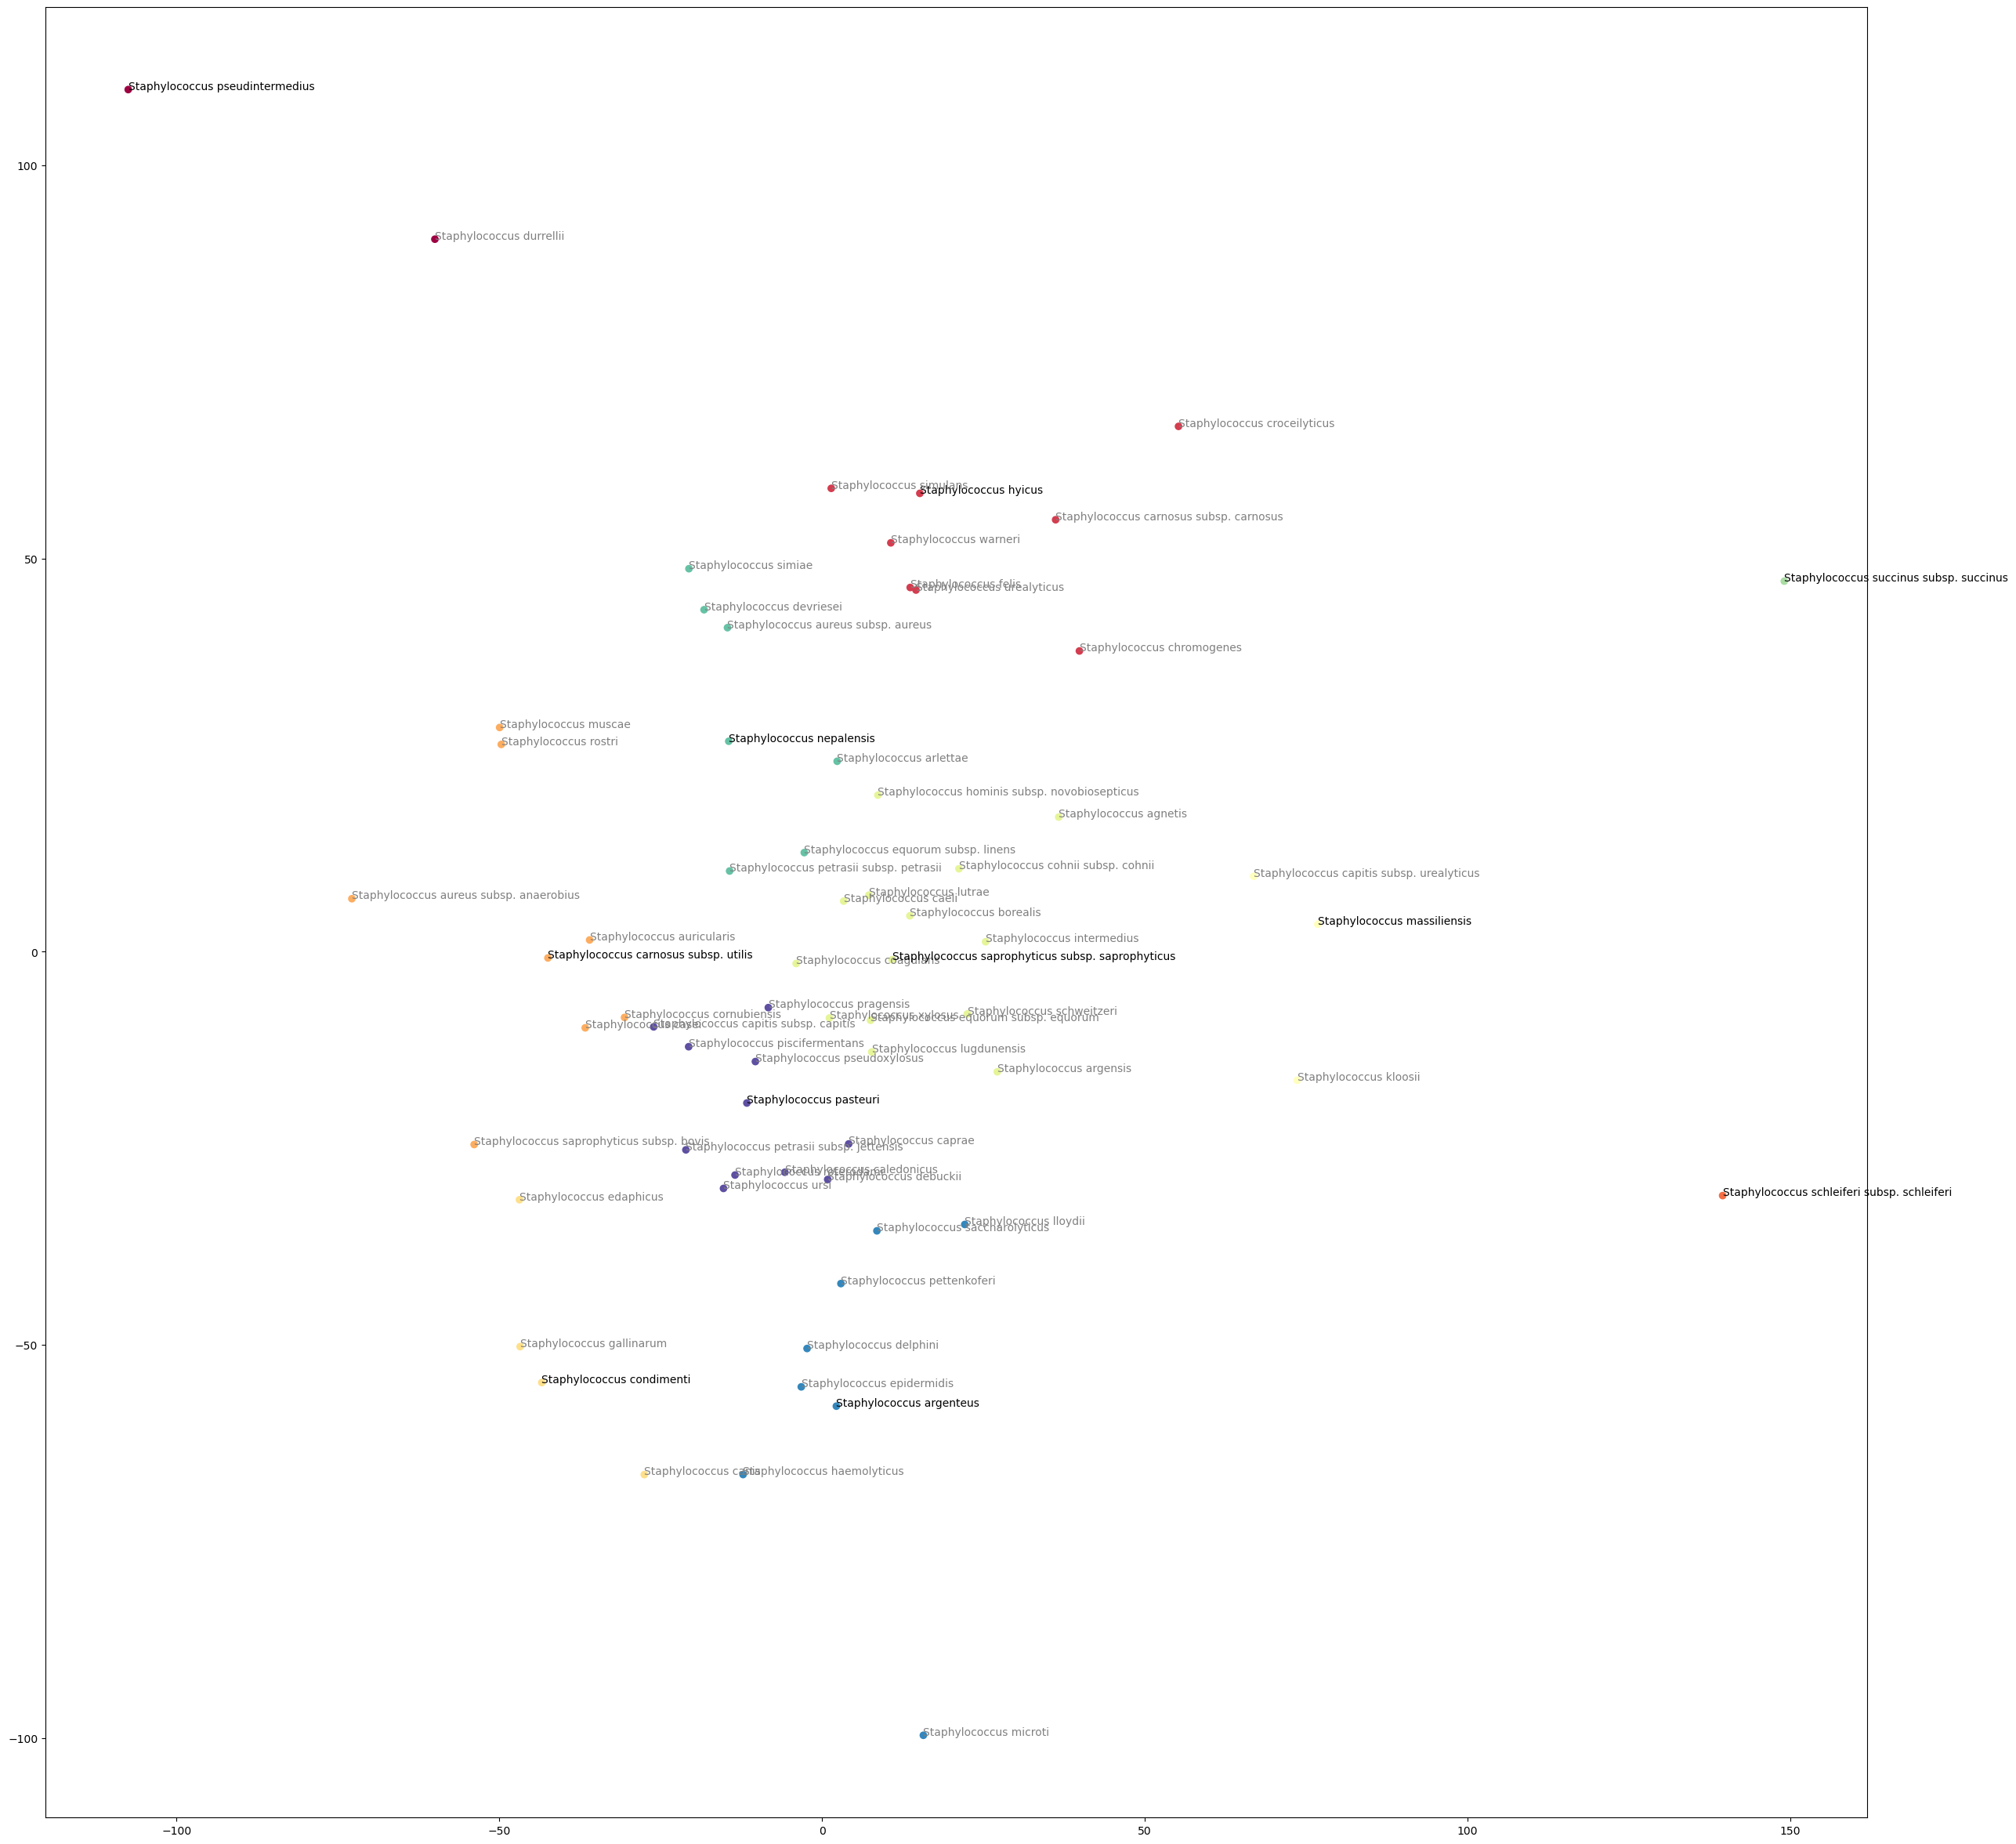

In [304]:
# from itertools import islice
from random import choices

# def take(n, iterable):
#     "Return first n items of the iterable as a list"
#     return dict(choices(iterable, k=n))

# random_sample = choices([{key: val} for key, val in seq_ids.items()], k=500)
random_sample = [{x['name']: seq_ids[x['name']]} for x in staph_strains]

random_sample_dict = {}
for item in random_sample:
    for key, val in item.items():
        random_sample_dict[key] = val
        
plot_nodes(random_sample_dict, figsize=(30, 30))

In [305]:
from sklearn.metrics import pairwise_distances

euclidian_distance = pairwise_distances(X=np.array([x for x in seq_ids.values()]), metric='euclidean')
cosine_distance = pairwise_distances(X=np.array([x for x in seq_ids.values()]), metric='cosine')
l1_distance = pairwise_distances(X=np.array([x for x in seq_ids.values()]), metric='l1')
jaccard_distance = pairwise_distances(X=np.array([x for x in seq_ids.values()]), metric='chebyshev')

In [306]:
def distance_matrix_to_file(distance_matrix, seq_ids: Dict[str, str], file_name: str = "../data/pwd_matrix.csv"):
    pass

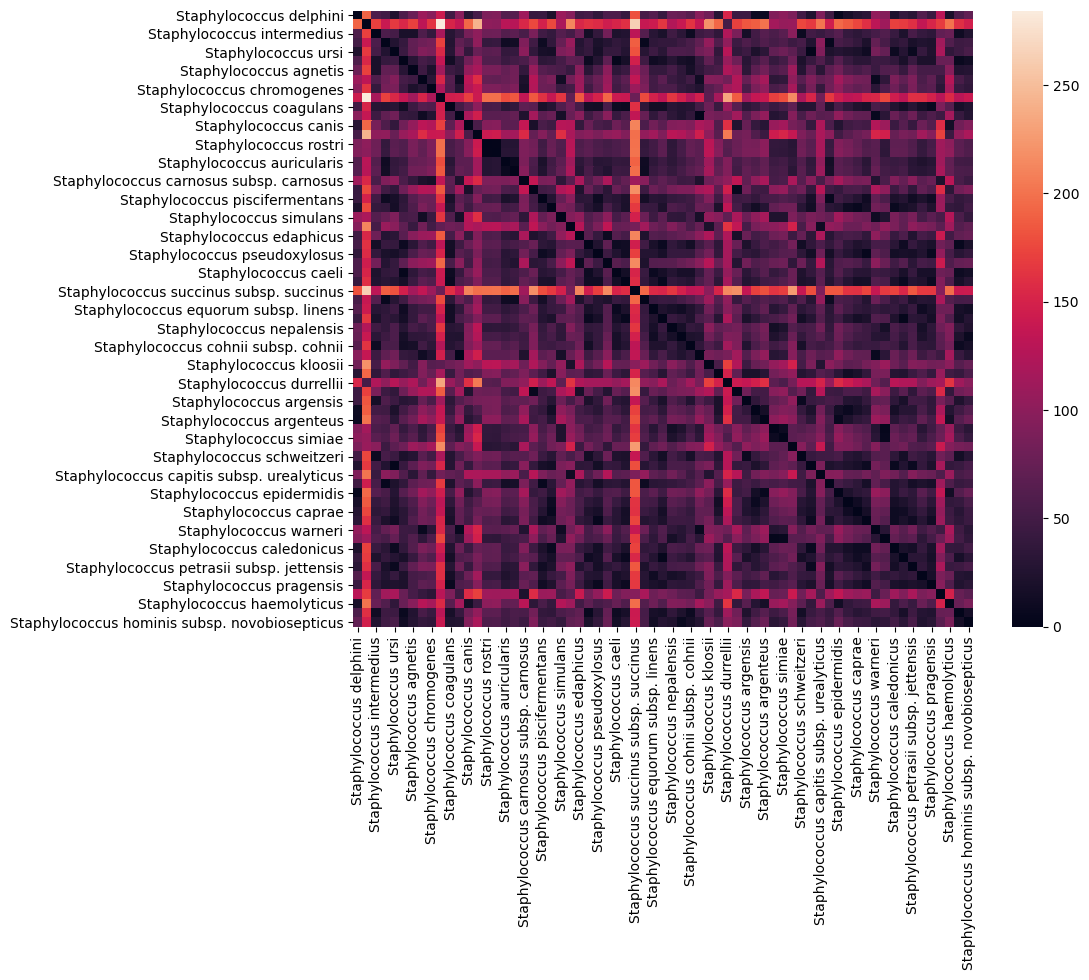

In [307]:
euclidian_distance_matrix = pd.DataFrame(euclidian_distance, index=seq_ids.keys(), columns=seq_ids.keys())
sns.heatmap(euclidian_distance_matrix)
plt.show()

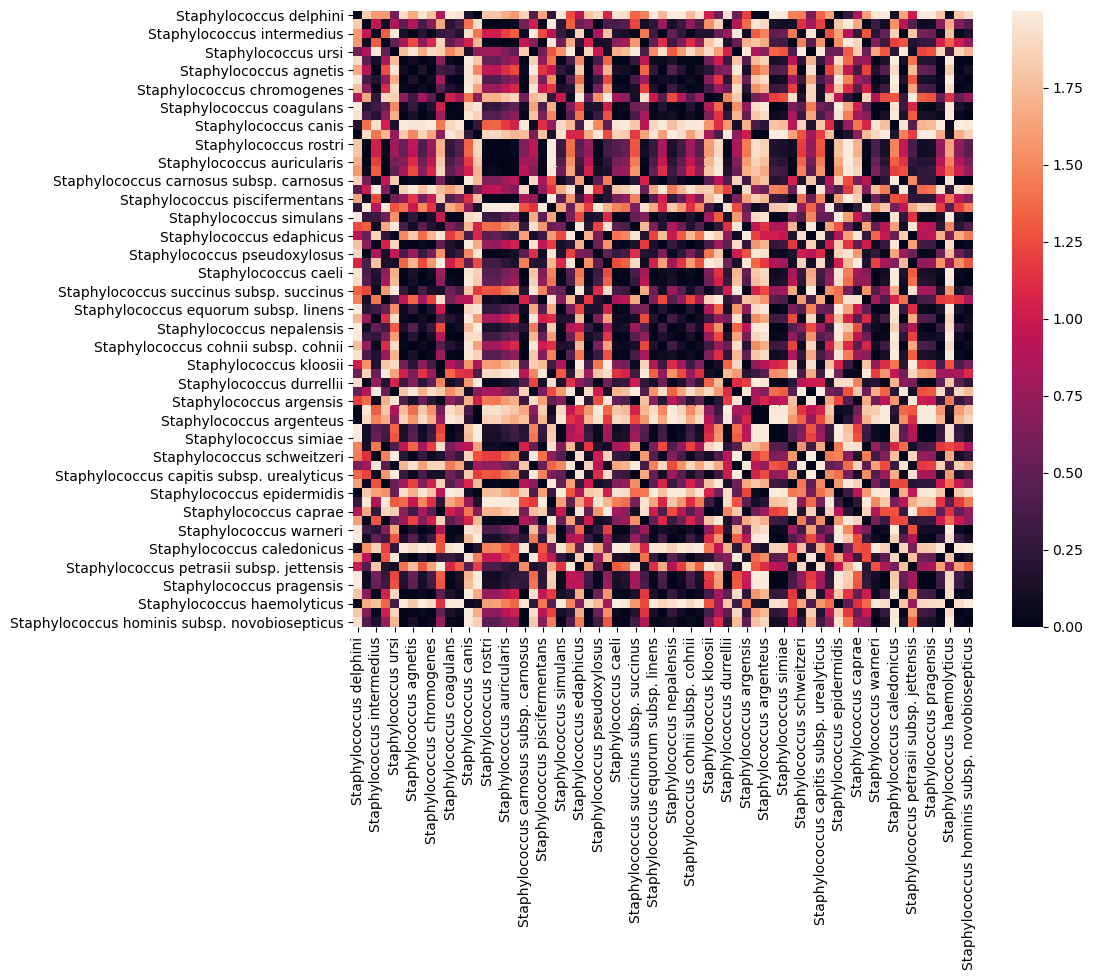

In [308]:
cosine_distance_matrix = pd.DataFrame(cosine_distance, index=seq_ids.keys(), columns=seq_ids.keys())
sns.heatmap(cosine_distance_matrix)
plt.show()

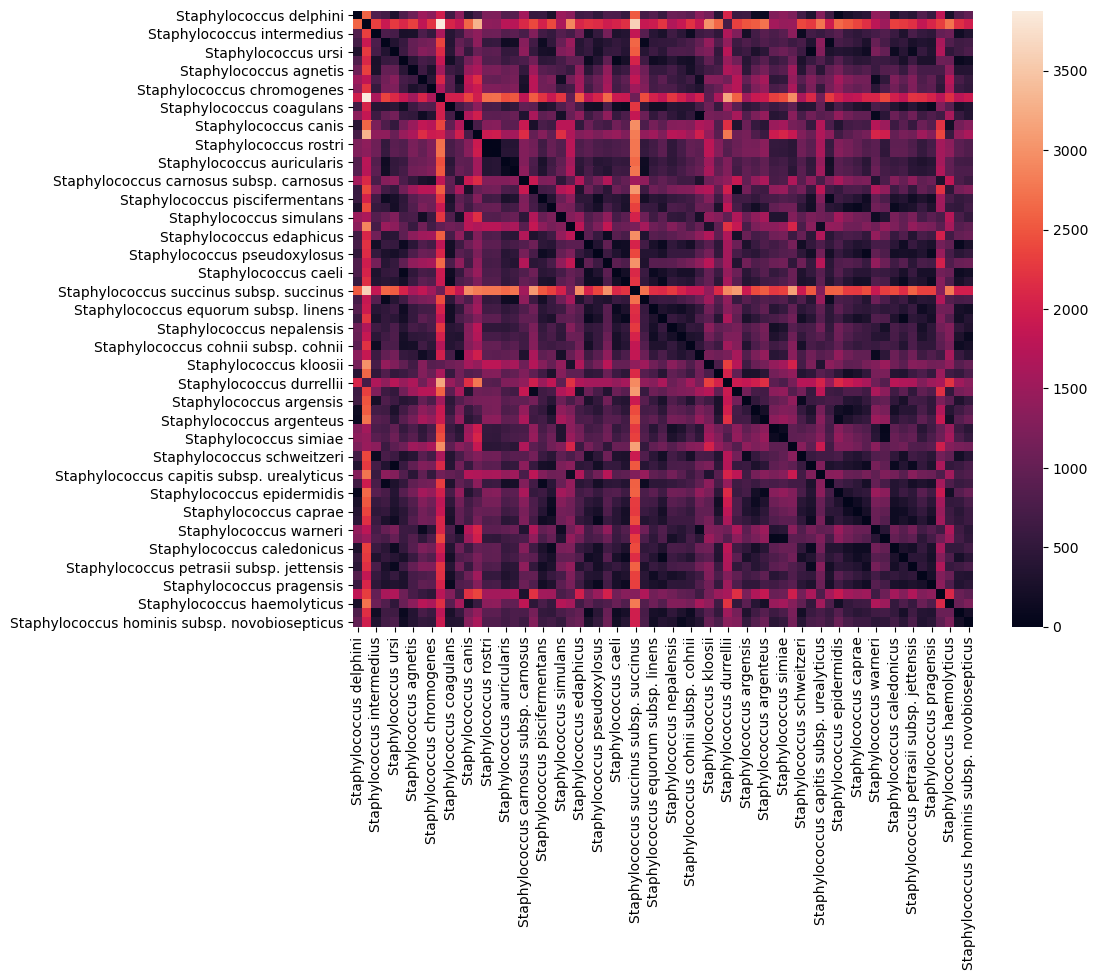

In [309]:
l1_distance_matrix = pd.DataFrame(l1_distance, index=seq_ids.keys(), columns=seq_ids.keys())
sns.heatmap(l1_distance_matrix)
plt.show()

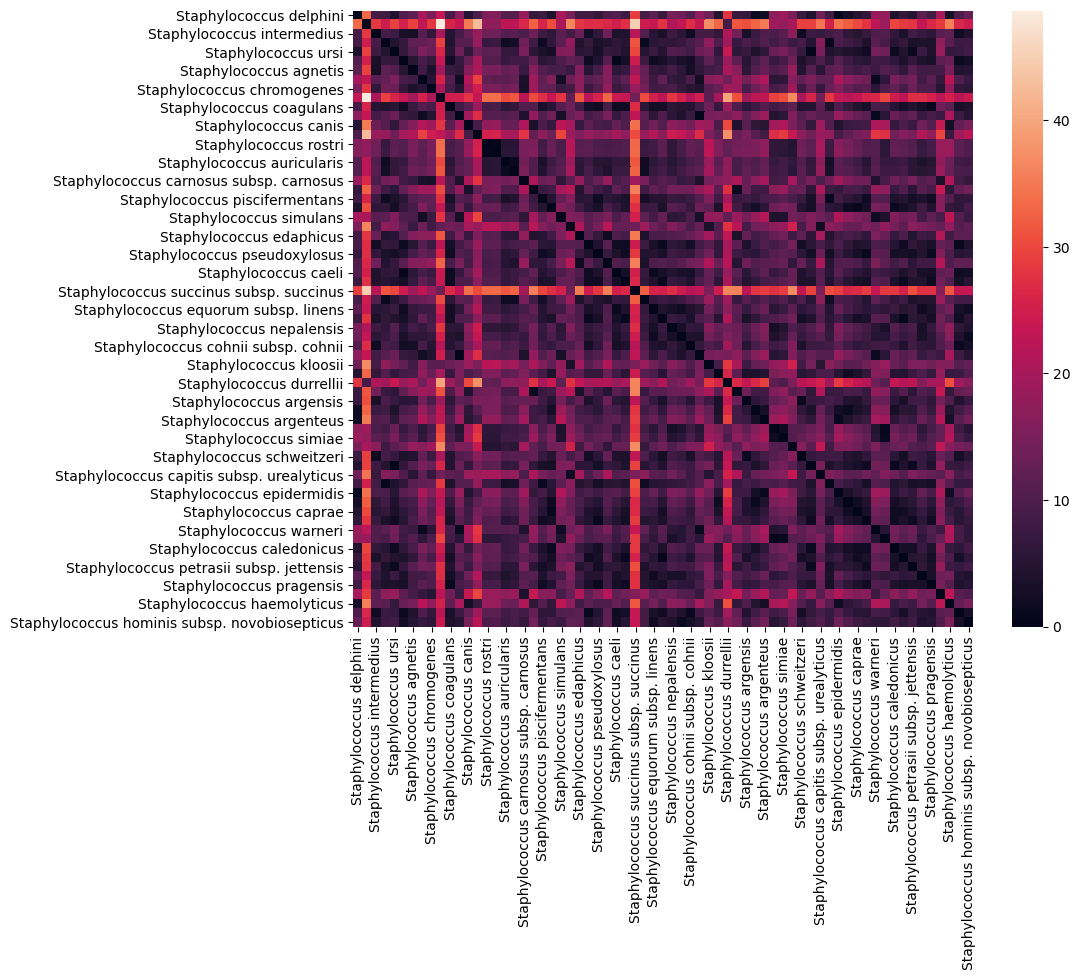

In [310]:
jaccard_distance_matrix = pd.DataFrame(jaccard_distance, index=seq_ids.keys(), columns=seq_ids.keys())
sns.heatmap(jaccard_distance_matrix)
plt.show()

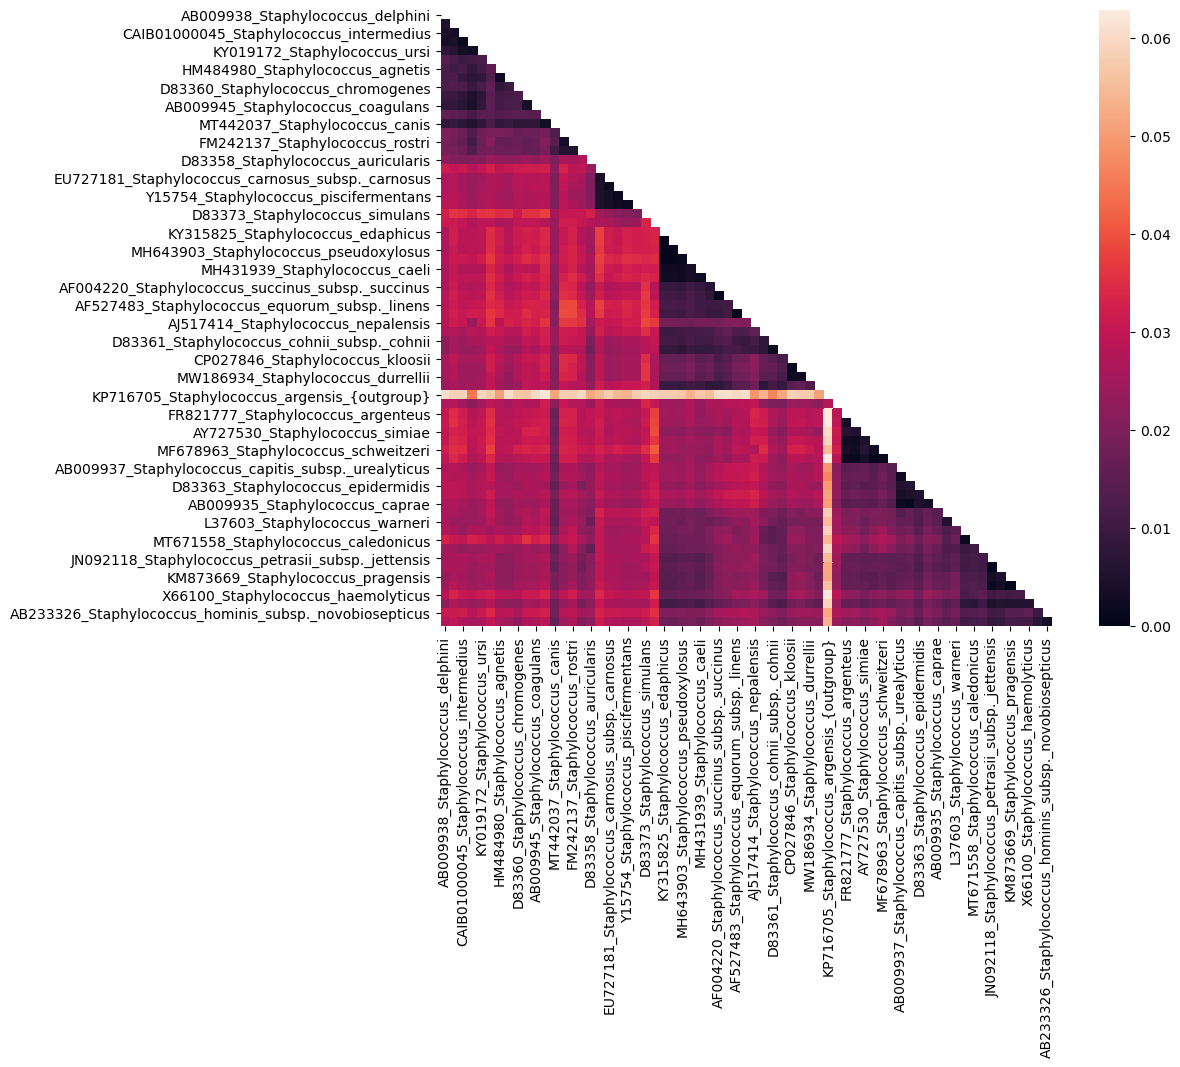

In [311]:
sns.heatmap(pd.read_csv("../data/LTP_09_2021_compressed_staph_distance_matrix.csv", index_col=0))
plt.show()

In [295]:
# Importing necessary libraries from BioPython
from Bio import Phylo, AlignIO
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor, DistanceMatrix

In [296]:
euc_lower = []

for idx, row in enumerate(euclidian_distance.tolist()):
    euc_lower.append(row[0:idx+1])
    
euc_lower

[[0.0],
 [191.16494750976562, 0.0],
 [436.67919921875, 563.9235229492188, 0.0],
 [65.62176513671875, 217.12557983398438, 478.5439453125, 0.0],
 [349.1505126953125,
  394.8917541503906,
  750.9705810546875,
  288.2055358886719,
  0.0],
 [37.952999114990234,
  166.4853515625,
  473.8001708984375,
  59.54632568359375,
  323.6892395019531,
  0.0],
 [145.63575744628906,
  62.00560760498047,
  508.0642395019531,
  186.1738739013672,
  405.3026123046875,
  128.92477416992188,
  0.0],
 [120.77803039550781,
  75.1128158569336,
  496.9627685546875,
  159.24169921875,
  386.47674560546875,
  103.55067443847656,
  30.141984939575195,
  0.0],
 [27.64914321899414,
  180.64895629882812,
  423.6301574707031,
  92.2667236328125,
  373.85858154296875,
  53.37976837158203,
  130.14698791503906,
  106.86373901367188,
  0.0],
 [301.7673645019531,
  111.2661361694336,
  658.8470458984375,
  322.8724670410156,
  449.12823486328125,
  275.0594482421875,
  166.35411071777344,
  185.3744659423828,
  291.5641784

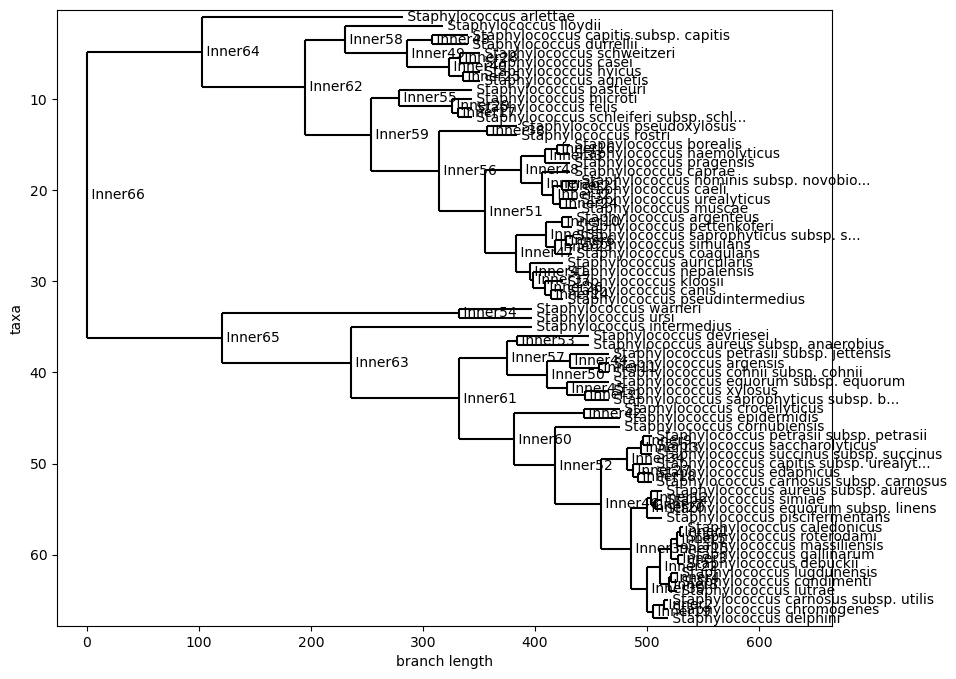

        _________ Staphylococcus arlettae
       |
       |       _____ Staphylococcus lloydii
       |      |
       |      |     _ Staphylococcus capitis subsp. capitis
       |     _|   ,|
       |    | |   ||_ Staphylococcus durrellii
  _____|    | |   |
 |     |    | |___|  , Staphylococcus schweitzeri
 |     |    |     | ,|
 |     |    |     | || Staphylococcus casei
 |     |    |     |_|
 |     |    |       |, Staphylococcus hyicus
 |     |    |       ||
 |     |    |        | Staphylococcus agnetis
 |     |____|
 |          |     ___ Staphylococcus pasteuri
 |          |   ,|
 |          |   ||  , Staphylococcus microti
 |          |   ||__|
 |          |   |   , Staphylococcus felis
 |          |   |   |
 |          |   |   | Staphylococcus schleiferi subsp. schl...
 |          |   |
 |          |   |      _ Staphylococcus pseudoxylosus
 |          |___|   __|
 |              |  |  |_ Staphylococcus rostri
 |              |  |
 |              |  |      , Staphylococcus boreali

In [297]:
# Calculate the distance matrix
distMatrix = DistanceMatrix([str(x) for x in seq_ids.keys()], euc_lower)

# Create a DistanceTreeConstructor object
constructor = DistanceTreeConstructor()
# Construct the phlyogenetic tree using UPGMA algorithm
UPGMATree = constructor.upgma(distMatrix)
# Construct the phlyogenetic tree using NJ algorithm
NJTree = constructor.nj(distMatrix)

# Draw the phlyogenetic tree
Phylo.draw(UPGMATree)
# Draw the phlyogenetic tree using terminal
Phylo.draw_ascii(UPGMATree)